Prior predictive check for the TrpB datasets.

In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd

import dms_stan.model as dms
import dms_stan.model.components as dms_components
import dms_stan.operations as dms_ops

In [36]:
def load_trpb_dataset(filepath: str) -> dict[str, npt.NDArray]:
    """
    Load a TrpB dataset from Johnston et al.
    """
    # Load in the data
    data = pd.read_csv(filepath)

    # Get the output columns
    output_cols = sorted(
        (col for col in data.columns if col.startswith("OutputCount")),
        key=lambda x: int(x.split("_")[1]),
    )

    # Get unique combo to input counts
    t0_data = data[["AAs", "InputCount_1"]].drop_duplicates()
    assert (t0_data.AAs.value_counts() == 1).all()
    combo_order = t0_data.AAs.tolist()
    t0_counts = t0_data.InputCount_1.to_numpy(dtype=int)

    # Get the timepoint counts
    times = data["Time (h)"].unique().astype(float)
    times.sort()
    tg0_counts = np.zeros([len(output_cols), len(times), len(combo_order)], dtype=int)
    for timeind, time in enumerate(times):

        # Filter down to just the data for this time
        time_data = data[data["Time (h)"] == time]

        # Make sure the data is in the right order
        assert time_data.AAs.tolist() == combo_order

        # Get the counts
        tg0_counts[:, timeind, :] = time_data[output_cols].to_numpy(dtype=int).T

    return {
        "times": np.concatenate([[0], times]),
        "starting_counts": t0_counts[-100:],
        "timepoint_counts": tg0_counts[..., -100:],
    }


class TrpBGrowthModel(dms.Model):
    """
    Models the TrpB count data from Johnston et al. using an exponential growth
    function to model the time-dependent increase in counts and a multinomial distribution
    to model the counts at each timepoint.
    """

    def __init__(
        self,
        times: npt.NDArray[np.floating],
        starting_counts: npt.NDArray[np.integer],
        timepoint_counts: npt.NDArray[np.integer],
    ):

        # Check shapes. Times and starting counts should be 1D arrays. Timepoint
        # counts should be a 3D array with shape (n_replicates, n_timepoints - 1, n_variants)
        if times.ndim != 1:
            raise ValueError("Times should be a 1D array")
        if starting_counts.ndim != 1:
            raise ValueError("Starting counts should be a 1D array")
        if timepoint_counts.ndim != 3:
            raise ValueError("Timepoint counts should be a 3D array")

        # Get the number of timepoints, replicates, and variants
        n_timepoints = len(times)
        n_replicates = timepoint_counts.shape[0]
        n_variants = timepoint_counts.shape[2]

        # Check that the shapes of the arrays are consistent
        if n_timepoints != timepoint_counts.shape[1] + 1:
            raise ValueError(
                "Timepoint counts should have one fewer timepoint than the number "
                "of times"
            )
        if starting_counts.shape[0] != n_variants:
            raise ValueError(
                "Starting counts and timepoint counts should have the same number "
                "of replicates"
            )

        # Normalize the times such that the maximum timepoint is 1
        times = times / times.max()
        if times[0] != 0.0:
            raise ValueError("Times should start at 0")

        # Now start building the generative model.
        # Hyperparameters first
        self.log_A = dms_components.Normal(mu=0.0, sigma=0.05, shape=(n_variants,))

        self.r_mean = dms_components.Exponential(beta=0.5, shape=(n_variants,))
        self.r_std = dms_components.HalfNormal(sigma=0.1)  # Shared across variants

        # Now the next layer of the model. Both technical replicates start from
        # the same culture, so the starting counts (and hence log_A) are the same.
        # The growth rate might vary between replicates, however, so we model a
        # separate one for each replicate.
        self.r = dms_components.Normal(
            mu=self.r_mean, sigma=self.r_std, shape=(n_replicates, 1, n_variants)
        )

        # Calculate the thetas at t = 0. This is just the log_A values normalized
        self.theta_t0 = dms_ops.exp(dms_ops.normalize_log(self.log_A))

        # Calculate the thetas a t > 0. This is the result of log exponential growth
        self.theta_tg0 = dms_ops.exp(
            dms_ops.normalize_log(
                dms_components.LogExponentialGrowth(
                    log_A=self.log_A,
                    r=self.r,
                    t=dms_components.Constant(times[None, 1:, None], togglable=False),
                    shape=(n_replicates, n_timepoints - 1, n_variants),
                )
            )
        )

        # Model the counts data.
        self.starting_counts = dms_components.Multinomial(
            theta=self.theta_t0,
            N=dms_components.Constant(starting_counts.sum(), togglable=False),
            shape=(n_variants,),
        ).as_observable()
        self.timepoint_counts = dms_components.Multinomial(
            theta=self.theta_tg0,
            N=dms_components.Constant(
                timepoint_counts.sum(axis=-1, keepdims=True), togglable=False
            ),
            shape=timepoint_counts.shape,
        ).as_observable()

        # Record the data
        self.times = times
        self.starting_counts_data = starting_counts
        self.timepoint_counts_data = timepoint_counts

    def approximate_map(self, *args, **kwargs):
        """Approximates the MAP estimate of the model."""
        return super().approximate_map(
            *args,
            **kwargs,
            starting_counts=self.starting_counts_data,
            timepoint_counts=self.timepoint_counts_data
        )

    @classmethod
    def from_data_file(cls, filepath: str):
        """
        Load a TrpB dataset from Johnston et al. and create a model from it.
        """
        return cls(**load_trpb_dataset(filepath))

In [37]:
data = load_trpb_dataset("~/GitRepos/DMSStan/raw_data/trpb/3-site_merged_replicates/LibI/20230926/LibI_merged_AAs.csv")
model = TrpBGrowthModel(**data)
map_estimate = model.approximate_map(lr = 1e-2)

Epochs:  14%|█▎        | 13527/100000 [01:14<07:56, 181.56it/s, -log pdf/pmf=75351.94]


In [41]:
map_estimate["distributions"]["timepoint_counts"].sample(100)

AttributeError: 'Multinomial' object has no attribute 'sample'

In [38]:
dms.plotting.plot_distribution(
    samples =
)

{'MAP': {'log_A': array([-0.25318246, -0.28688896,  0.44459915, -0.12388674,  0.58766054,
          2.03144339, -0.12970933,  3.42798351,  1.75080915,  1.0716944 ,
          1.40377671,  0.00514275,  0.2671251 ,  1.32408363,  1.25264903,
          0.14851905, -0.40296422,  0.0154452 , -0.30580073, -0.27002925,
         -0.79670549, -0.43225261, -0.27666444, -0.14933601, -0.21269179,
          0.0880554 ,  0.75831905, -0.09769598,  2.55923248,  0.89569518,
          0.37775858,  1.31453157, -0.07207095,  0.37961447,  0.89161375,
          0.55835266, -0.42084694, -0.53567053,  0.24029652, -0.40541716,
         -0.55036836, -0.74673409, -0.47824643, -0.53687862, -0.27083326,
         -0.49790713, -0.42148984,  0.61604213, -0.37453673,  2.18377868,
          0.03694445, -0.39790117,  0.32484057, -0.22784982, -0.48505968,
          0.13158741,  0.43985759, -0.50077825, -0.50040866, -0.29047977,
         -0.47407305, -0.39828454, -0.49104684, -0.45368623, -0.39743783,
         -0.22099051, 

In [39]:
ratios = (data["timepoint_counts"] / data["starting_counts"])

<Axes: >

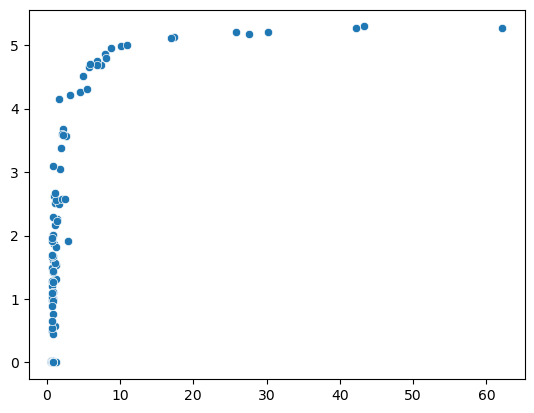

In [40]:
import seaborn as sns
import scipy.stats as stats
sns.scatterplot(x = ratios.mean(axis=(0,1)), y=map_estimate["MAP"]["r_mean"])